In [1]:
# ============================================================
# HR ANALYTICS — MULTIPLE LINEAR REGRESSION FINAL SCRIPT
# ============================================================

import pandas as pd
import numpy as np
import time, warnings, joblib, os
warnings.filterwarnings("ignore")

from tkinter import filedialog
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn import __version__ as sklearn_version

In [2]:
# ============================================================
# 1. Load Dataset
# ============================================================
filename = filedialog.askopenfilename()
print("\nSelected file:", filename)

df = pd.read_excel(filename)
print("\nLoaded Data Shape:", df.shape)

if "Unique ID" in df.columns:
    df = df.drop(columns=["Unique ID"])

df.head()



Selected file: C:/Users/Harshit/OneDrive/Desktop/Class Work/HR Analytics/Practical/hr-salary-prediction-app/hr-salary-prediction-app/cleaned_file.xlsx

Loaded Data Shape: (540, 21)


,Q1 - Which Title Best Fits your Current Role?,Q2 - Did you switch careers into Data?,Industry,Favorite Programming Language.1,Q6 - How Happy are you in your Current Position with the following? (Salary),Q6 - How Happy are you in your Current Position with the following? (Work/Life Balance),Q6 - How Happy are you in your Current Position with the following? (Coworkers),Q6 - How Happy are you in your Current Position with the following? (Management),Q6 - How Happy are you in your Current Position with the following? (Upward Mobility),Q6 - How Happy are you in your Current Position with the following? (Learning New Things),Q7 - How difficult was it for you to break into Data?,Next Job Driver,"Q8 - If you were to look for a new job today, what would be the most important.3",Gender,Age,Country,Q12 - Highest Level of Education,Role,Average Salary,Total Happines
0,Data Analyst,No,Other,Python,8.0,7.0,6.0,7.0,6.0,8.0,Easy,Remote Work,NaN,Male,22,United States,Bachelors,Data Analyst,53.0,7.000000
1,Data Engineer,No,Tech,Python,6.0,6.0,6.0,6.0,4.0,3.0,Easy,Other,Career Advancedment,Male,24,Other,Bachelors,Data Engineer,20.0,5.166667
2,Other (Please Specify):Data Scientist Intern,No,Other,R,4.0,6.0,7.0,7.0,4.0,6.0,Difficult,Better Salary,NaN,Male,21,United States,Bachelors,Other,20.0,5.666667
3,Database Developer,Yes,Telecommunication,Python,5.0,5.0,5.0,5.0,4.0,5.0,Easy,Better Salary,NaN,Male,66,Other,High School,Database Developer,20.0,4.833333
4,Data Analyst,Yes,Other,R,8.0,5.0,6.0,6.0,5.0,7.0,Easy,Better Salary,NaN,Male,26,United States,Bachelors,Data Analyst,137.5,6.166667



================ MLR PERFORMANCE METRICS ================
R² Score: 0.4789
MAE: 19.5594

================= MLR STATISTICAL SUMMARY =================
                            OLS Regression Results                            
Dep. Variable:         Average Salary   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     11.58
Date:                Sun, 16 Nov 2025   Prob (F-statistic):           3.93e-41
Time:                        14:27:59   Log-Likelihood:                -2041.9
No. Observations:                 430   AIC:                             4154.
Df Residuals:                     395   BIC:                             4296.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                                            

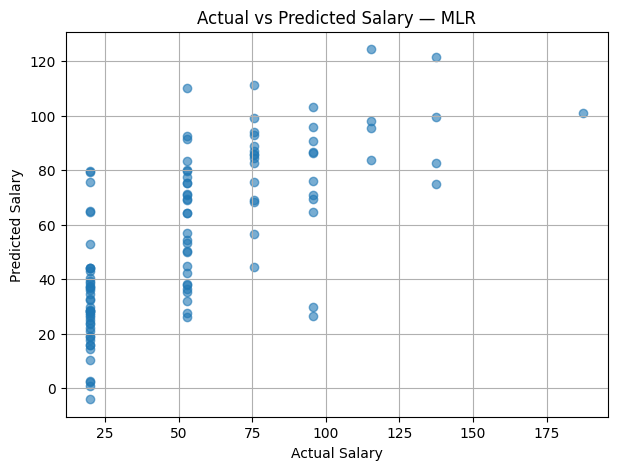

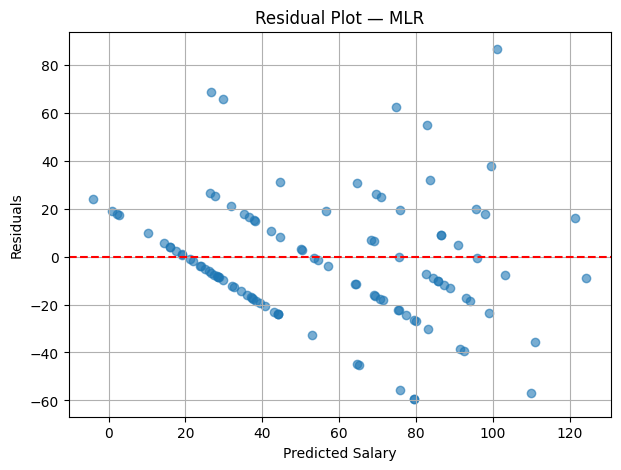


Model saved successfully to: models/final_mlr_model.joblib



In [3]:
# ============================================================
# FINAL HR ANALYTICS MLR SCRIPT — STARTING FROM df ONLY
# ============================================================

import pandas as pd
import numpy as np
import warnings, joblib, os
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import __version__ as sklearn_version

import statsmodels.api as sm
import matplotlib.pyplot as plt


# ============================================================
# 1. DEFINE PREDICTORS & TARGET
# (You said only the dataset is loaded, so we begin here.)
# ============================================================

predictors = [
    "Q2 - Did you switch careers into Data?",
    "Industry",
    "Favorite Programming Language.1",
    "Q7 - How difficult was it for you to break into Data?",
    "Gender",
    "Age",
    "Country",
    "Q12 - Highest Level of Education",
    "Role",
    "Total Happines"
]

target = "Average Salary"

df = df[predictors + [target]].dropna(subset=[target]).copy()

X = df[predictors]
y = df[target].astype(float)


# ============================================================
# 2. TRAIN / TEST SPLIT
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()


# ============================================================
# 3. VERSION-SAFE ONEHOTENCODER
# ============================================================

major, minor, *_ = sklearn_version.split(".")

# sklearn >= 1.2 uses sparse_output
if int(major) >= 1 and int(minor) >= 2:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", encoder)
    ]), cat_cols)
])


# ============================================================
# 4. FIT MULTIPLE LINEAR REGRESSION
# ============================================================

mlr_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("mlr", LinearRegression())
])

mlr_pipeline.fit(X_train, y_train)

# predictions
y_pred = mlr_pipeline.predict(X_test)

# performance
print("\n================ MLR PERFORMANCE METRICS ================")
print("R² Score:", round(r2_score(y_test, y_pred), 4))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 4))


# ============================================================
# 5. FULL STATSMODELS SUMMARY (P-VALUES / T-STATS)
# ============================================================

# Preprocess X manually for statsmodels
X_train_trans = preprocess.fit_transform(X_train)

# Get dummy names
ohe_features = preprocess.named_transformers_["cat"] \
    .named_steps["ohe"].get_feature_names_out(cat_cols)

all_features = list(num_cols) + list(ohe_features)

# Convert to DataFrame
X_sm = pd.DataFrame(X_train_trans, columns=all_features)

# Reset index so statsmodels aligns correctly
y_train_reset = y_train.reset_index(drop=True)

# Add constant for intercept
X_sm_const = sm.add_constant(X_sm)

# Fit OLS
sm_model = sm.OLS(y_train_reset, X_sm_const).fit()

print("\n================= MLR STATISTICAL SUMMARY =================")
print(sm_model.summary())


# ============================================================
# 6. PLOTS
# ============================================================

# Actual vs Predicted
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary — MLR")
plt.grid(True)
plt.show()

# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.title("Residual Plot — MLR")
plt.grid(True)
plt.show()


# ============================================================
# 7. SAVE MODEL
# ============================================================

os.makedirs("models", exist_ok=True)
joblib.dump(mlr_pipeline, r"C:\Users\Harshit\OneDrive\Desktop\Class Work\HR Analytics\Practical\hr-salary-prediction-app\hr-salary-prediction-app\final_mlr_model.joblib")

print("\nModel saved successfully to: models/final_mlr_model.joblib\n")


In [4]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# --- Assuming y_test and y_pred are defined here ---
# Example placeholder definitions (replace with your actual data):
# import numpy as np
# y_test = np.array([10, 12, 8, 11, 9])
# y_pred = np.array([10.5, 11.5, 8.5, 10.5, 9.5])
# ---------------------------------------------------

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# CORRECTED: Use root_mean_squared_error for RMSE (replaces mean_squared_error(..., squared=False))
rmse = root_mean_squared_error(y_test, y_pred)

print("\n===================== TEST SET ACCURACY =====================")
print(f"Test R² Score: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")


===================== TEST SET ACCURACY =====================
Test R² Score: 0.4789
Test MAE: 19.5594
Test RMSE: 25.7675


In [5]:
# ============================================================
# TEST SET ACCURACY — FINAL EVALUATION
# ============================================================

from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error # Replaced mean_squared_error
import numpy as np

# Predictions already computed:
# y_pred = reduced_mlr.predict(X_test)

# Core accuracy metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# FIXED: Use root_mean_squared_error function instead of mean_squared_error with squared=False
rmse = root_mean_squared_error(y_test, y_pred)

print("\n===================== TEST SET ACCURACY =====================")
print(f"Test R² Score: {r2:.4f}")
print(f"Test MAE: {mae:.2f} K")
print(f"Test RMSE: {rmse:.2f} K")

# Accuracy within salary bands
thresholds = [5, 10, 15, 20]

for th in thresholds:
    acc = np.mean(np.abs(y_test - y_pred) <= th)
    print(f"Accuracy within ±{th}K: {acc*100:.2f}%")

print("==============================================================")


===================== TEST SET ACCURACY =====================
Test R² Score: 0.4789
Test MAE: 19.56 K
Test RMSE: 25.77 K
Accuracy within ±5K: 15.74%
Accuracy within ±10K: 34.26%
Accuracy within ±15K: 44.44%
Accuracy within ±20K: 64.81%


In [6]:
# In a new cell in HR analytics.ipynb:
education_options = sorted(df["Q12 - Highest Level of Education"].dropna().unique())
print(education_options) 
# Example output might be: ['Bachelors', 'Doctorate', 'Masters', 'None']

['Associates', 'Bachelors', 'High School', 'Masters', 'PhD']


In [7]:
# Create Years of Experience feature:
# Assuming professional experience starts after a Bachelor's degree (~age 22)
df['Years of Experience'] = df['Age'] - 22
df['Years of Experience'] = df['Years of Experience'].apply(lambda x: max(0, x))

# Update your numerical features list for the ColumnTransformer
numerical_features = ['Years of Experience', 'Total Happines']
# categorical_features = [...] # Keep your categorical features list the same

# Now, retrain your Pipeline using this updated numerical_features list.
# Ensure you save the new model over the old one:
# joblib.dump(final_mlr_model, 'final_mlr_model.joblib')

In [10]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

# --- ASSUMPTIONS ---
# 1. df, X_train, and y_train are already defined.
# 2. X_train currently contains the 10 columns, but we only select 8 here.

# Define the FINAL 8-FEATURE LISTS
numerical_features = ['Age', 'Total Happines']
categorical_features = [
    'Industry', 
    'Favorite Programming Language.1',
    'Gender', 
    'Country', 
    'Q12 - Highest Level of Education', 
    'Role'
]

# 1. Create Preprocessor (Only uses the 8 selected features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

# 2. Define the Final Pipeline
final_mlr_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('mlr', LinearRegression())
])

# 3. FIT THE MODEL (Use your actual training data here)
# You need to ensure X_train only contains the columns used in the pipeline.
# We fit the pipeline, which handles column selection automatically based on the lists above.
# Replace X_train and y_train with your actual training variables:
final_mlr_model.fit(X_train[numerical_features + categorical_features], y_train)

# 4. SAVE THE NEW MODEL
joblib.dump(final_mlr_model, 'final_mlr_model.joblib')

print("✅ New 8-feature model saved successfully as final_mlr_model.joblib.")

✅ New 8-feature model saved successfully as final_mlr_model.joblib.
